In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import skimage as ski
import pandas as pd

In [2]:

train_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q1/mlds-assignmet-2-ml-dl/Dataset/train'
test_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q1/mlds-assignmet-2-ml-dl/Dataset/test'

train_csv_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q1/mlds-assignmet-2-ml-dl/train.csv'
test_csv_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q1/mlds-assignmet-2-ml-dl/test.csv'

In [3]:
## Implement a class of dataset to get the data
class ImageDataset:
    def __init__(self, data_dir_path, is_train = True):
        self.data_dir_path = data_dir_path
        self.is_train = is_train
        dirs = os.listdir(data_dir_path)
        for dir in dirs:
            if dir == 'images':
                self.images_path = glob(os.path.join(data_dir_path, dir, '*.png'))
            if dir == 'masks':
                self.labels_path = glob(os.path.join(data_dir_path, dir, '*.png'))
        self.images_path.sort()
        self.labels_path.sort()
        
    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        if idx >= len(self.images_path):
            print('Reduce the index count as it is greater than the length of the dataset')
            return None
        if idx < 0:
            print('Index should be greater than or equal to 0')
            return None
        data = {}
        data['image'] = plt.imread(self.images_path[idx])
        data['label'] = plt.imread(self.labels_path[idx])

        #resize the image and label to 32x32
        data['image'] = ski.transform.resize(data['image'], (32, 32))
        data['label'] = ski.transform.resize(data['label'], (32, 32))
        return data

In [4]:
"""
id : Name of the image
Binary prediction
    Healthy = 0
    Diseased = 1
segmentation prediction
    Probably the id of the diseased pixel
"""
train_csv_data = pd.read_csv(train_csv_path)
#Sort train_csv_data by id
train_csv_data = train_csv_data.sort_values(by='id')
train_csv_data.head(10)


,id,binary_pred,segmentation_pred
0,0.png,1,27797 2 28053 4 28063 2 28309 15 28565 19 2882...
1,1.png,1,3629 4 3883 8 4137 12 4390 17 4644 21 4898 25 ...
10,10.png,0,Healthy
100,100.png,1,19931 7 20187 10 20443 10 20699 10 20955 10 21...
101,101.png,1,6392 4 6645 7 6899 9 7150 15 7394 27 7645 32 7...
102,102.png,1,8475 1 8730 4 8986 5 9242 6 9498 7 9754 9 1001...
103,103.png,0,Healthy
104,104.png,0,Healthy
105,105.png,1,17528 1 17781 5 17846 1 18034 9 18102 2 18287 ...
106,106.png,1,23612 5 23866 9 24121 9 24377 6 29270 25 29524...


In [5]:
train_data = ImageDataset(train_path)

In [6]:

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.u = None
        self.s = None
        self.v = None
        self.mean_vec = None
        self.std_dev = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # Make data zero mean and unit variance
        self.mean_vec = np.mean(X,axis=0)
        self.std_vec = np.std(X, axis=0)
        X = (X - self.mean_vec) / self.std_vec
        # Perform SVD
        self.u, self.s, self.v = np.linalg.svd(X)
        
        # Calculate explained variance ratio
        self.total_variance = np.sum(self.s**2)
        self.explained_variance_ratio = (self.s**2) / self.total_variance
        self.cumulative_variance_ratio = np.cumsum(self.explained_variance_ratio)
        
        # Select the first n_components singular values if n_components is +ve integer
        if isinstance(self.n_components, int) and self.n_components > 0:
            self.used_components = min(self.n_components, len(self.s))
            self.u = self.u[:, :self.used_components]
            self.s = self.s[:self.used_components]
            self.v = self.v[:self.used_components, :]
            self.variance_explained = np.sum(self.explained_variance_ratio[:self.used_components])

        else:
            # If n_components is a float between 0 and 1, treat it as variance threshold
            for i in range(len(self.s)):
                if np.sum(self.s[:i]**2)/np.sum(self.s**2) >= self.n_components:
                    self.used_components = i
                    break
            if not hasattr(self, 'used_components'):
                self.used_components = len(self.s)
            self.u = self.u[:, :self.used_components]
            self.s = self.s[:self.used_components]
            self.v = self.v[:self.used_components, :]
            self.variance_explained = np.sum(self.explained_variance_ratio[:self.used_components])
            
    def transform(self, X):
        # Project the data
        return np.dot(self.u, np.diag(self.s))

    def inverse_transform(self, X):
        # Reconstruct the data
        return np.dot(X, self.v) * self.std_vec + self.mean_vec
        

In [7]:
def process_image_data(data):
    # get all training image in a list
    train_images = []
    red_channel = np.zeros((len(train_data), 32, 32))
    green_channel = np.zeros((len(train_data), 32, 32))
    blue_channel = np.zeros((len(train_data), 32, 32))
    for i in range(len(train_data)):
        image = train_data.__getitem__(i)
        red_channel[i] = image['image'][:,:,0]
        green_channel[i] = image['image'][:,:,1]
        blue_channel[i] = image['image'][:,:,2]
        train_images.append(image['image'])
    
    
    train_images = np.array(train_images)
    red_channel = np.array(red_channel)
    green_channel = np.array(green_channel)
    blue_channel = np.array(blue_channel)
    
    red_channel_flatten = red_channel.reshape(red_channel.shape[0], -1)
    green_channel_flatten = green_channel.reshape(green_channel.shape[0], -1)
    blue_channel_flatten = blue_channel.reshape(blue_channel.shape[0], -1)

    return red_channel_flatten, green_channel_flatten, blue_channel_flatten, train_images

In [8]:
   
def perform_pca(data, n_components):
    """This function performs PCA on the given data:
    Args: 
        data: pass class dataset [number of samples, Height, width, channel]
        n_components: Percentage of total info to retain in PCA or number of component to retain
    Returns:
        recon_data: np array of reconstructed data after dimensionality reduction
        variances: dictionary with variance information for each channel
    """
    red_channel_flatten, green_channel_flatten, blue_channel_flatten, train_images = process_image_data(data)
    
    # Initialize variance dictionary
    variances = {
        'red': {},
        'green': {},
        'blue': {},
        'average': {}
    }
    
    # Perform PCA on red channel
    pca_red = PCA(n_components)
    pca_red.fit(red_channel_flatten)
    red_channel_reduced = pca_red.transform(red_channel_flatten)
    red_channel_recon = pca_red.inverse_transform(red_channel_reduced)
    variances['red']['components'] = pca_red.used_components
    variances['red']['variance_explained'] = pca_red.variance_explained
    variances['red']['cumulative_variance'] = pca_red.cumulative_variance_ratio[:pca_red.used_components]

    # Perform PCA on green channel
    pca_green = PCA(n_components)
    pca_green.fit(green_channel_flatten)
    green_channel_reduced = pca_green.transform(green_channel_flatten)
    green_channel_recon = pca_green.inverse_transform(green_channel_reduced)
    variances['green']['components'] = pca_green.used_components
    variances['green']['variance_explained'] = pca_green.variance_explained
    variances['green']['cumulative_variance'] = pca_green.cumulative_variance_ratio[:pca_green.used_components]

    # Perform PCA on blue channel
    pca_blue = PCA(n_components)
    pca_blue.fit(blue_channel_flatten)
    blue_channel_reduced = pca_blue.transform(blue_channel_flatten)
    blue_channel_recon = pca_blue.inverse_transform(blue_channel_reduced)
    variances['blue']['components'] = pca_blue.used_components
    variances['blue']['variance_explained'] = pca_blue.variance_explained
    variances['blue']['cumulative_variance'] = pca_blue.cumulative_variance_ratio[:pca_blue.used_components]
    
    # Calculate average variance explained across all channels
    variances['average']['variance_explained'] = (variances['red']['variance_explained'] + 
                                                 variances['green']['variance_explained'] + 
                                                 variances['blue']['variance_explained']) / 3
    
    # Stack channels to reconstruct the image
    train_images_recon = np.stack([red_channel_recon, green_channel_recon, blue_channel_recon], axis=-1)
    shape_train_recon = train_images_recon.shape
    train_images_recon_reshaped = train_images_recon.reshape(shape_train_recon[0], 32, 32, 3)
    
    return train_images_recon_reshaped, variances

In [9]:
# List of different n_components values to test
N_COMPONENTS = [10, 50, 100, 200, 500, 1000]
image_idx = 50
images_for_different_components = []
variance_results = {}

# Get original image for comparison
original_image = train_data.__getitem__(image_idx)['image']

# Perform PCA with different numbers of components and collect results
for component in N_COMPONENTS:
    image, variance_info = perform_pca(train_data, component)
    images_for_different_components.append(image[image_idx])
    variance_results[component] = variance_info['average']['variance_explained']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08448984201517029..0.8665533373849617].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07479111145879458..0.9995551925547759].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08643837960708256..0.9172433789134656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006566989563737302..0.9126635352136558].


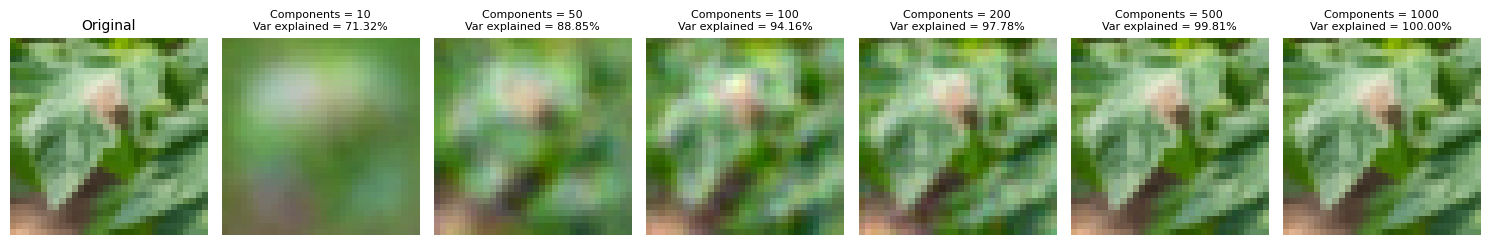

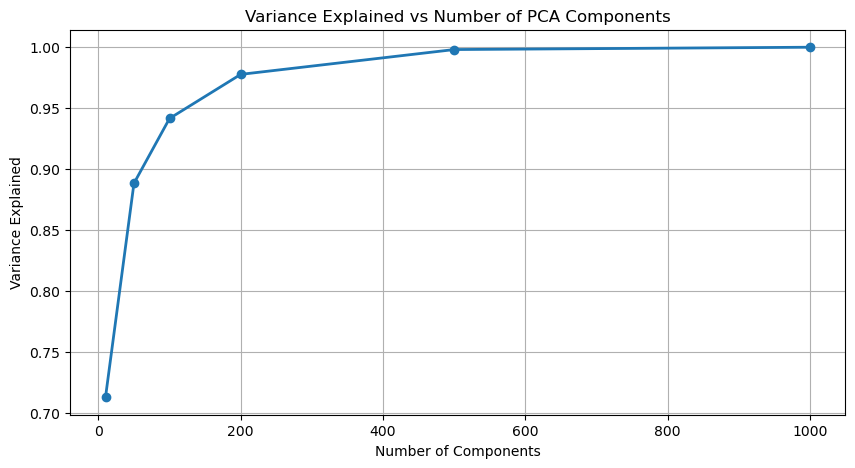

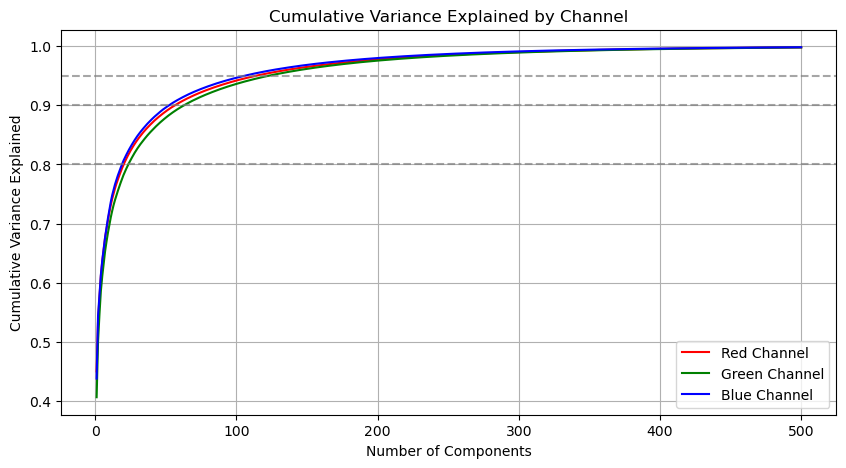

In [10]:
# Plot reconstructed images and original
fig, axes = plt.subplots(1, len(N_COMPONENTS) + 1, figsize=(15, 4))
axes[0].imshow(original_image)
axes[0].set_title("Original", fontsize=10)
axes[0].axis('off')

for i, component in enumerate(N_COMPONENTS):
    axes[i+1].imshow(images_for_different_components[i])
    axes[i+1].set_title(f"Components = {component}\nVar explained = {variance_results[component]:.2%}", fontsize=8)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# Plot variance explained vs number of components
plt.figure(figsize=(10, 5))
plt.plot(N_COMPONENTS, [variance_results[c] for c in N_COMPONENTS], 'o-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained vs Number of PCA Components')
plt.grid(True)
plt.show()

# Get component-wise variance analysis for a specific number of components (e.g., 100)
detailed_component = 500
_, detailed_variance = perform_pca(train_data, detailed_component)

# Plot cumulative variance explained for each channel
plt.figure(figsize=(10, 5))
max_len = min(len(detailed_variance['red']['cumulative_variance']), 
              len(detailed_variance['green']['cumulative_variance']), 
              len(detailed_variance['blue']['cumulative_variance']))

x_values = range(1, max_len + 1)
plt.plot(x_values, detailed_variance['red']['cumulative_variance'][:max_len], 'r-', label='Red Channel')
plt.plot(x_values, detailed_variance['green']['cumulative_variance'][:max_len], 'g-', label='Green Channel')
plt.plot(x_values, detailed_variance['blue']['cumulative_variance'][:max_len], 'b-', label='Blue Channel')

# Add horizontal lines at common variance thresholds
plt.axhline(y=0.8, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.7)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Channel')
plt.legend()
plt.grid(True)
plt.show()


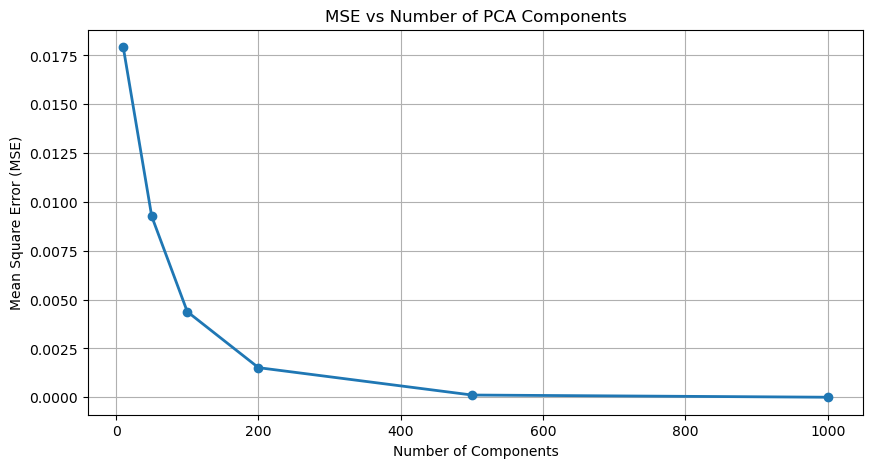

In [ ]:
# Find the mean square error between the original and reconstructed images
def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

# Calculate MSE for each component
mse_results = {}
for component in N_COMPONENTS:
    image, _ = perform_pca(train_data, component)
    mse = calculate_mse(original_image, image[image_idx])
    mse_results[component] = mse
# Plot MSE results
plt.figure(figsize=(10, 5))
plt.plot(N_COMPONENTS, mse_results.values(), 'o-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Mean Square Error (MSE)')
plt.title('MSE vs Number of PCA Components')
plt.grid(True)
plt.show()

## Observation
From the above graphs we can see that at 500 components the MSE between image and projected image is almost 0 and the variance explained by the reconstructed image is very close to 1. hence selecting 500 component will halve the number of dimension from 1024 to 500 making it less compute intensive with maximal information extraction.